# Import for building essentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import shutil
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report
import torch
from imblearn.over_sampling import SMOTE
import zipfile
import os
from PIL import Image
import random
import pandas as pd
import numpy as np

# Download shared data dir at Drive

In [ ]:
!rm -rf /content/data

In [ ]:
!rm -rf /content/data/TODO

## Load data split

In [ ]:
!cp -r /content/drive/MyDrive/validation /content/data

# Define dataloader and data transformation via torchvision

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.00255
EPOCHES = 30
THRESHOLD = 0.4

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

class DatasetImageCustom(datasets.DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ):
        super().__init__(
            root,
            loader,
            datasets.folder.IMG_EXTENSIONS,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        # Extract the filename from the path
        path = self.samples[index][0]
        filename = os.path.basename(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, filename

In [ ]:
testdir = "/content/drive/MyDrive/validation"
test_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

test_data = DatasetImageCustom(testdir,transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)
torch.save(testloader, '/content/testloader_with_transforms.pth')
#testloader = torch.load('/content/testloader_with_transforms.pth')

In [ ]:
traindir = "/content/drive/MyDrive/training"

#transformations
train_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                       transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])

#datasets
train_data = DatasetImageCustom(traindir,transform=train_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=BATCH_SIZE)

## End load data splited

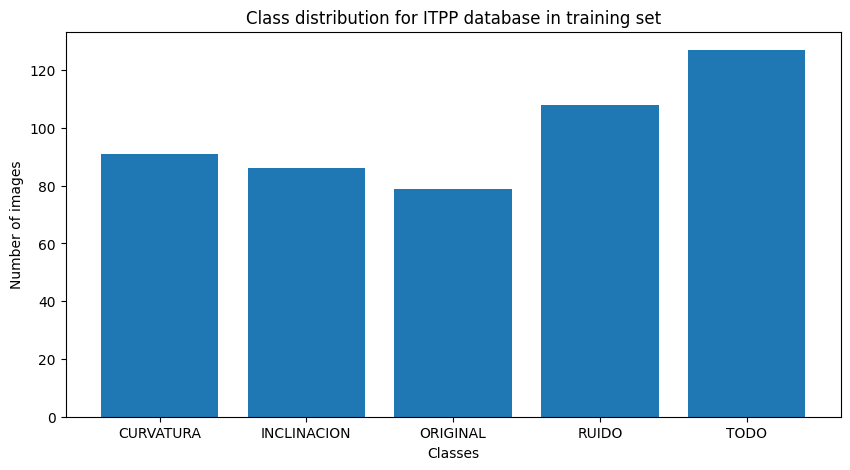

In [ ]:
import matplotlib.pyplot as plt
import os

# Count the number of images in each class in the training directory
class_counts = {}
classes=["CURVATURA","INCLINACION", "ORIGINAL", "RUIDO", "TODO"]
for class_name in classes[:]:
    class_dir = os.path.join(traindir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in training set")
#plt.show()
plt.savefig('training_set_ITPP.pdf', format='pdf')

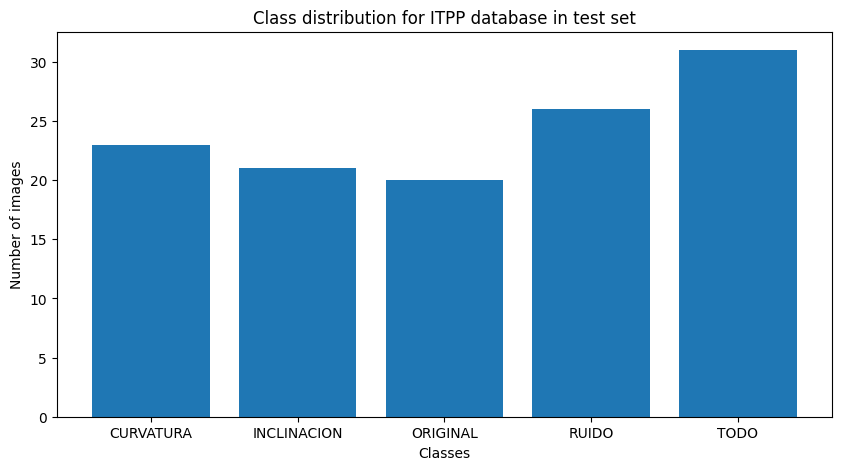

In [ ]:
class_counts = {}
for class_name in classes[:]:
    class_dir = os.path.join(testdir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in test set")
#plt.show()
plt.savefig('test_set_ITPP.pdf', format='pdf')

# Define model and trainer

In [ ]:
class ModelWithSigmoid(nn.Module):
    def __init__(self, model, labels):
        super(ModelWithSigmoid, self).__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()  # Apply softmax along the class dimension

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

# Model definition

In [ ]:
# Function to count the total number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Include fined labels for todo

In [ ]:
def get_todo_labels(image_sample_name):
    reverse_mapping_classes = ['CURVATURA', 'INCLINACION', 'ORIGINAL', 'RUIDO']
    one_hot_labels = [0, 0, 0 ,0]
    for index, label in enumerate(reverse_mapping_classes):
        if label in image_sample_name:
            one_hot_labels[index] = 1

    return one_hot_labels

In [ ]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y, image_sample_name):
        yhat = model(x)
        #y=y.squeeze(1).to(torch.int64)
        model.train()
        label_one_hot=[]
        for index, label in enumerate(y):
            if label < 4:
                label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
            else:
                encoded_label = get_todo_labels(image_sample_name[index])
                label_one_hot.append(encoded_label) # [1,1,0,1] for all

        label_one_hot = torch.tensor(label_one_hot).to(device)
        loss = loss_fn(yhat,label_one_hot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    return train_step

device = "cuda" if torch.cuda.is_available() else "cpu"
model_base = models.alexnet(pretrained=True)

#freeze all params
#for params in model_base.parameters():
    #params.requires_grad_ = False

#add a new final layer
nr_filters = model_base.classifier[6].in_features  #number of input features of last layer
print("features space out: ", nr_filters)

# Replace the final fully connected layer with a new one
model_base.classifier[6] = nn.Linear(nr_filters, 4)

model = ModelWithSigmoid(model_base, 4)#

model = model.to(device)

#loss
loss_fn = nn.BCELoss()

for name, param in model.named_parameters():
    if not any(layer_name in name for layer_name in ['model.classifier.6']):
        param.requires_grad = False
    else:
      print(name, 'is not freeze')

# Count the parameters
total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#train step
train_step = make_train_step(model, optimizer, loss_fn)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


features space out:  4096
model.classifier.6.weight is not freeze
model.classifier.6.bias is not freeze
Total parameters: 57020228
Trainable parameters: 16388


# Train model with early stoping

# Load model for continue training

In [ ]:
model_path = "/content/drive/MyDrive/trained_model_alexnet_base_threshold.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = EPOCHES
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
        x_batch , y_batch, image_sample_name = data
        x_batch = x_batch.to(device) #move to gpu
        y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu


        loss = train_step(x_batch, y_batch, image_sample_name)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)

    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

    #validation doesnt requires gradient
    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch, image_sample_name in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch)
            #y_batch=y_batch.squeeze(1).to(torch.int64)

            label_one_hot=[]
            for index, label in enumerate(y_batch):
                if label < 4:
                    label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
                else:
                    encoded_label = get_todo_labels(image_sample_name[index])
                    label_one_hot.append(encoded_label) # [1,1,0,1] for all

            label_one_hot = torch.tensor(label_one_hot).to(device)
            val_loss = loss_fn(yhat,label_one_hot)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())


        epoch_test_losses.append(cum_loss)
        print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))

        best_loss = min(epoch_test_losses)

        #save best model
        if cum_loss <= best_loss:
            best_model_wts = model.state_dict()

        #early stopping
        early_stopping_counter = 0
        if cum_loss > best_loss:
            early_stopping_counter +=1

        if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
            print("/nTerminating: early stopping")
            break #terminate training

#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 31/31 [04:41<00:00,  9.08s/it]



Epoch : 1, train loss : 0.6148171424865723
Epoch : 1, val loss : 0.4646329879760742


100%|██████████| 31/31 [01:52<00:00,  3.63s/it]



Epoch : 2, train loss : 0.5691092014312744
Epoch : 2, val loss : 0.5185770392417908


100%|██████████| 31/31 [01:49<00:00,  3.52s/it]



Epoch : 3, train loss : 0.5448839068412781
Epoch : 3, val loss : 0.7216668128967285


100%|██████████| 31/31 [01:49<00:00,  3.54s/it]



Epoch : 4, train loss : 0.5591031312942505
Epoch : 4, val loss : 0.3448042571544647


100%|██████████| 31/31 [01:48<00:00,  3.49s/it]



Epoch : 5, train loss : 0.5458412170410156
Epoch : 5, val loss : 0.44174835085868835


100%|██████████| 31/31 [01:49<00:00,  3.52s/it]



Epoch : 6, train loss : 0.5150802731513977
Epoch : 6, val loss : 0.5586361289024353


100%|██████████| 31/31 [01:49<00:00,  3.52s/it]



Epoch : 7, train loss : 0.5157256126403809
Epoch : 7, val loss : 0.6999049782752991


100%|██████████| 31/31 [01:49<00:00,  3.54s/it]



Epoch : 8, train loss : 0.5244078040122986
Epoch : 8, val loss : 0.48218390345573425


100%|██████████| 31/31 [01:49<00:00,  3.55s/it]



Epoch : 9, train loss : 0.5258231163024902
Epoch : 9, val loss : 0.7549338340759277


100%|██████████| 31/31 [01:48<00:00,  3.51s/it]



Epoch : 10, train loss : 0.5279237627983093
Epoch : 10, val loss : 0.7280941009521484


100%|██████████| 31/31 [01:54<00:00,  3.70s/it]



Epoch : 11, train loss : 0.5363900661468506
Epoch : 11, val loss : 0.40705567598342896


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 12, train loss : 0.5150079727172852
Epoch : 12, val loss : 0.5688727498054504


100%|██████████| 31/31 [01:46<00:00,  3.45s/it]



Epoch : 13, train loss : 0.48201754689216614
Epoch : 13, val loss : 0.5203938484191895


100%|██████████| 31/31 [01:51<00:00,  3.60s/it]



Epoch : 14, train loss : 0.5400224924087524
Epoch : 14, val loss : 0.8255966901779175


100%|██████████| 31/31 [01:46<00:00,  3.45s/it]



Epoch : 15, train loss : 0.5166767239570618
Epoch : 15, val loss : 0.45807361602783203


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 16, train loss : 0.5144425630569458
Epoch : 16, val loss : 0.5610800385475159


100%|██████████| 31/31 [01:47<00:00,  3.47s/it]



Epoch : 17, train loss : 0.49578338861465454
Epoch : 17, val loss : 0.33221307396888733


100%|██████████| 31/31 [01:47<00:00,  3.46s/it]



Epoch : 18, train loss : 0.49041420221328735
Epoch : 18, val loss : 0.47043412923812866


100%|██████████| 31/31 [01:49<00:00,  3.53s/it]



Epoch : 19, train loss : 0.4874691069126129
Epoch : 19, val loss : 0.4721512496471405


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 20, train loss : 0.5152953863143921
Epoch : 20, val loss : 0.39039427042007446


100%|██████████| 31/31 [01:47<00:00,  3.47s/it]



Epoch : 21, train loss : 0.48979267477989197
Epoch : 21, val loss : 0.47446104884147644


100%|██████████| 31/31 [01:46<00:00,  3.44s/it]



Epoch : 22, train loss : 0.4885903298854828
Epoch : 22, val loss : 0.5120700001716614


100%|██████████| 31/31 [01:45<00:00,  3.42s/it]



Epoch : 23, train loss : 0.5105758309364319
Epoch : 23, val loss : 0.384268581867218


100%|██████████| 31/31 [01:46<00:00,  3.42s/it]



Epoch : 24, train loss : 0.5204908847808838
Epoch : 24, val loss : 0.49551060795783997


100%|██████████| 31/31 [01:45<00:00,  3.41s/it]



Epoch : 25, train loss : 0.53885817527771
Epoch : 25, val loss : 0.5910668969154358


100%|██████████| 31/31 [01:46<00:00,  3.45s/it]



Epoch : 26, train loss : 0.511777400970459
Epoch : 26, val loss : 0.5895796418190002


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]



Epoch : 27, train loss : 0.5145711302757263
Epoch : 27, val loss : 0.737343430519104


100%|██████████| 31/31 [01:47<00:00,  3.46s/it]



Epoch : 28, train loss : 0.5028902888298035
Epoch : 28, val loss : 0.4351659119129181


100%|██████████| 31/31 [01:47<00:00,  3.47s/it]



Epoch : 29, train loss : 0.5200172662734985
Epoch : 29, val loss : 0.5952546000480652


100%|██████████| 31/31 [01:46<00:00,  3.42s/it]



Epoch : 30, train loss : 0.5197120904922485
Epoch : 30, val loss : 0.5458284020423889


<All keys matched successfully>

#Model evaluation

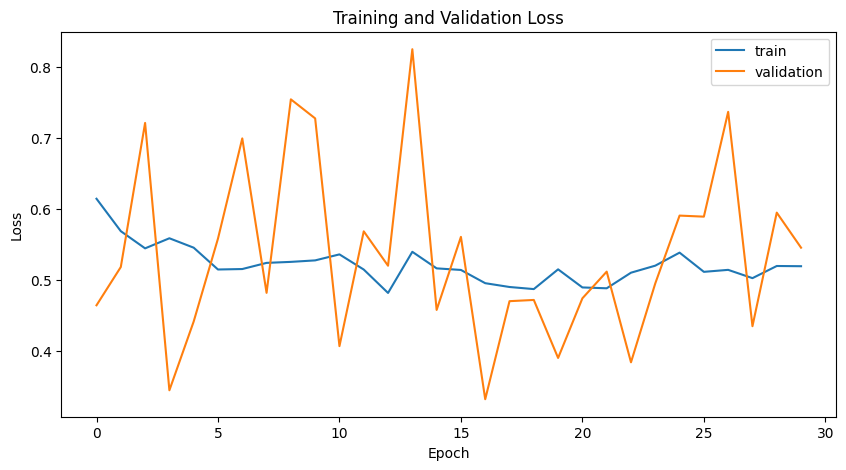

In [ ]:
t_loss=[val.cpu().detach().numpy() for val in epoch_train_losses]
v_loss=[val.cpu().numpy() for val in epoch_test_losses]
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(t_loss, label="train")
plt.plot(v_loss, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/TVL_trained_model_alexnet_base_threshold.pdf', format='pdf')

In [ ]:
def predict_with_thresholds(model, dataloader, device, thresholds):
    """
    Predicts class labels using custom thresholds for each class.

    Args:
        model: The PyTorch model.
        dataloader: The DataLoader for the test data.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        thresholds: A list of thresholds, one for each class.

    Returns:
        A list of predicted labels and a list of true labels.
    """
    y_pred = []
    y_true = []

    todo_performance_analize = []

    with torch.no_grad():
        for x_batch, y_batch, image_sample_name in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()  # Convert target to same nn output shape
            y_batch = y_batch.to(device)
            model.eval()
            yhat = model(x_batch)
            predictions = yhat.cpu().numpy()

            for i in range(predictions.shape[0]):
                predicted_classes = []
                predicted_classes_ponderations = []
                for j in range(predictions.shape[1]):
                    if predictions[i][j] > thresholds[j]:
                        predicted_classes.append(j)
                        predicted_classes_ponderations.append(predictions[i][j])
                if len(predicted_classes) == 0:
                        y_pred.append(2)
                elif len(predicted_classes) == 1:
                    y_pred.append(predicted_classes[0])

                elif len(predicted_classes) > 1 and 2 not in predicted_classes:
                    predicted_classes_ponderations = np.array(predicted_classes_ponderations)
                    score = np.sum(predicted_classes_ponderations)
                    y_pred.append(4)
                else:
                    max_index = np.argmax(predictions[i])
                    y_pred.append(max_index)

            y_true.extend(y_batch.cpu().numpy().flatten())

    return y_pred, y_true, todo_performance_analize

thresholds =  [0.5, 0.5, 0.5, 0.5]#[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

print(classification_report(y_true, y_pred,digits=4, target_names=test_data.classes))

              precision    recall  f1-score   support

   CURVATURA     0.8000    0.5217    0.6316        23
 INCLINACION     0.5000    0.1905    0.2759        21
    ORIGINAL     0.3333    0.7000    0.4516        20
       RUIDO     0.5385    0.5385    0.5385        26
        TODO     0.6667    0.6452    0.6557        31

    accuracy                         0.5289       121
   macro avg     0.5677    0.5192    0.5107       121
weighted avg     0.5804    0.5289    0.5263       121



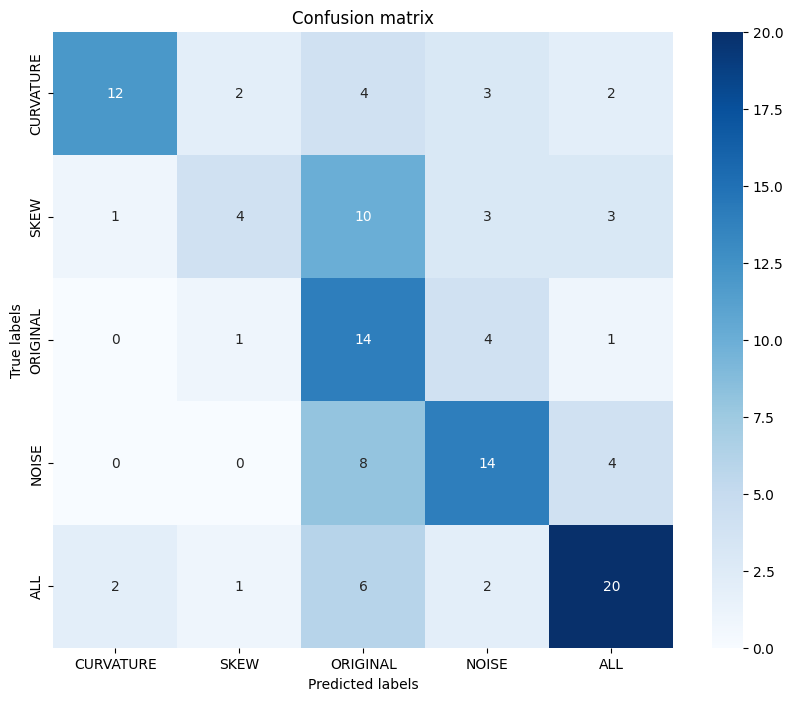

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_alexnet_base_threshold.pdf', format='pdf')

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/trained_model_alexnet_base_threshold.pth')


In [ ]:
# prompt: create all measures f1, macro F, roc

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# ... (your existing code) ...

thresholds =  [0.5, 0.5, 0.5, 0.5] #[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

# Calculate F1-score (macro average)
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {f1_macro}")

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")

# Classification report
print(classification_report(y_true, y_pred, digits=4, target_names=test_data.classes))


# Calculate ROC AUC score (requires probabilities, not just predictions)
# Binarize the labels for ROC AUC calculation
y_true_binarized = label_binarize(y_true, classes=np.unique(y_pred))

# Assuming your model outputs probabilities
y_prob = []
with torch.no_grad():
    for x_batch, y_batch, image_sample_name in testloader:
        x_batch = x_batch.to(device)
        model.eval()
        yhat = model(x_batch)
        y_prob.extend(yhat.cpu().numpy())
y_prob = np.array(y_prob)

# Calculate ROC AUC for each class
roc_auc_scores = []
n_classes = y_true_binarized.shape[1]
for i in range(4):
    roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
    roc_auc_scores.append(roc_auc)

print(f"ROC AUC scores for each class: {roc_auc_scores}")

# Calculate the macro average of the ROC AUC scores
macro_roc_auc = np.mean(roc_auc_scores)
print(f"Macro-averaged ROC AUC: {macro_roc_auc}")


Macro F1-score: 0.5106506325878631
Macro Precision: 0.5676923076923076
Macro Recall: 0.5191676299390184
              precision    recall  f1-score   support

   CURVATURA     0.8000    0.5217    0.6316        23
 INCLINACION     0.5000    0.1905    0.2759        21
    ORIGINAL     0.3333    0.7000    0.4516        20
       RUIDO     0.5385    0.5385    0.5385        26
        TODO     0.6667    0.6452    0.6557        31

    accuracy                         0.5289       121
   macro avg     0.5677    0.5192    0.5107       121
weighted avg     0.5804    0.5289    0.5263       121

ROC AUC scores for each class: [0.540150842945874, 0.5030952380952382, 0.558910891089109, 0.5216599190283401]
Macro-averaged ROC AUC: 0.5309542227896403


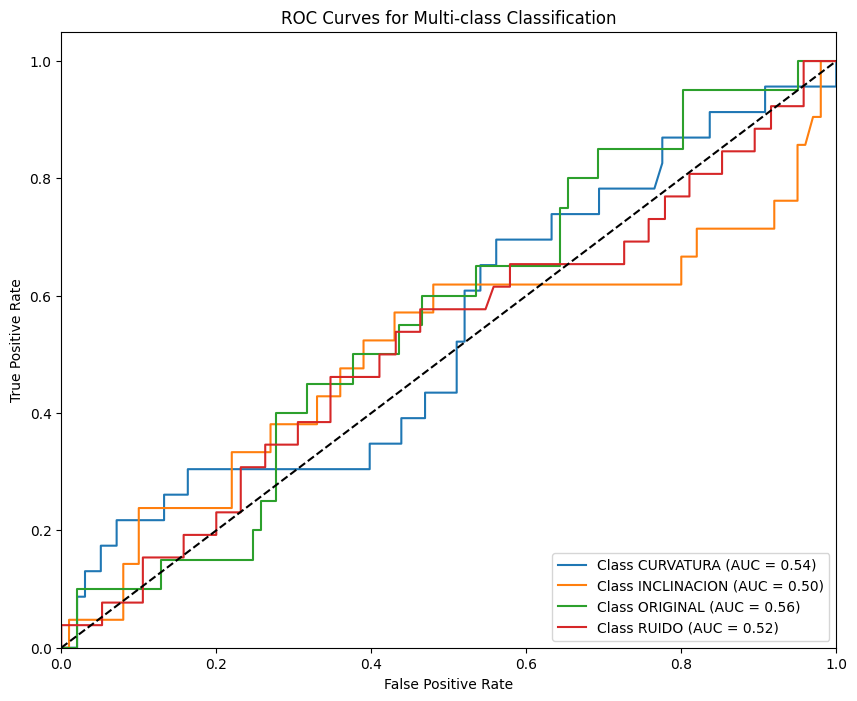

In [ ]:
# prompt: generate chart from ROC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true_binarized and y_prob are defined as in your previous code

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {test_data.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/ROC_trained_model_alexnet_base_threshold.pdf', format='pdf')


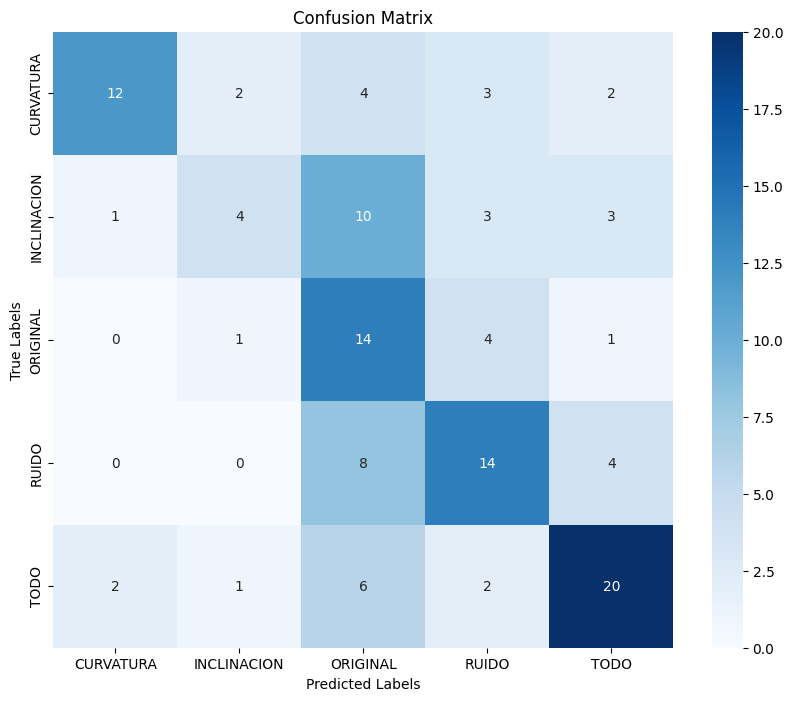

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/CM_trained_model_alexnet_base_threshold.pdf', format='pdf')